# Install

In [1]:
! pip install fastai2 -q

     |████████████████████████████████| 194kB 2.8MB/s 


# Import

In [0]:
from fastai2.data.external import untar_data, URLs
from fastai2.data.transforms import get_image_files

# Dataset

In [3]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
len(files), files[0]

(7390, Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_194.jpg'))

# Preparing Data

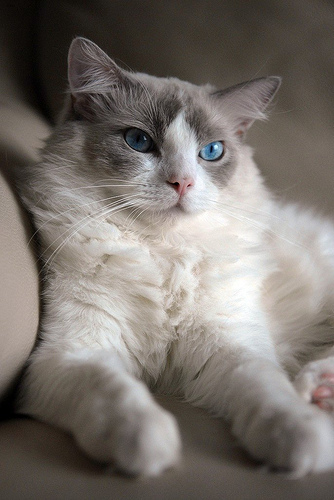

In [4]:
import PIL
img = PIL.Image.open(files[0])
img

In [0]:
import torch
import numpy as np

## Open image files

In [0]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2, 0, 1).float()/255.0

In [7]:
t = open_image(files[0])
t.shape

torch.Size([3, 224, 224])

## Labeling

In [0]:
import re

In [0]:
def label_func(fname):
    return re.match(r'^(.*)_\d+\.jpg$', fname.name).groups()[0]

In [10]:
l = label_func(files[0])
l

'Ragdoll'

In [11]:
labels = list(set(files.map(label_func)))
len(labels)

37

## Creating util dict

In [0]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

In [0]:
# lbl2files

# Creating Custom Dataset

In [0]:
import random

## Define SiameseDataset class

In [0]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files, self.is_valid = files, is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]

    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls])
        return random.choice(lbl2files[cls]), same

    def __getitem__(self, i):
        file1 = self.files[i]
        (file2, same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1, img2 = open_image(file1), open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())

    def __len__(self):
        return len(self.files)

## Split

เอาเลข Running ตามจำนวนไฟล์ มา สับไพ่ Random แล้วเลือกตัดเป็น 2 ส่วน 80/20 นำมาใช้ดึงรายการไฟล์ใส่ Training Set / Validation Set

In [0]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

นำข้อมูลรายการไฟล์ที่ได้ มาสร้าง Dataset 2 SiameseDataset

In [0]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

# DataLoaders

ใช้ 2 Dataset ที่ได้มาสร้าง DataLoaders

In [0]:
from fastai2.data.core import DataLoaders

In [19]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)
dls

เรายังเรียก show_batch ไม่ได้ เพราะยังไม่ได้กำหนดวิธีแสดงผล เราจะลองดึงข้อมูลดู ด้วย one_batch

In [0]:
b = dls.one_batch()
# b

ถ้าต้องการให้ DataLoaders ของเรา ย้ายข้อมูลไปใช้ GPU ก็เพียงแค่สั่ง

In [21]:
dls.cuda()

# Transform

ในวิธีการเดียวกันกับที่เราสร้าง SiameseDataset เราสามารถนำมาสร้าง Transform เพื่อใช้ใน Data Pipeline สำหรับป้อนให้โมเดล

In [0]:
from fastai2.vision.all import *

In [0]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files, self.is_valid = files, is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
    
    def encodes(self, i):
        file1 = self.files[i]
        (file2, same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1, img2 = open_image(file1), open_image(file2)
        return (TensorImage(img1), TensorImage(img2), Tensor([same]).squeeze())

    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls])
        return random.choice(lbl2files[cls]), same

In [0]:
train_tl = TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl = TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

In [0]:
# train_tl

In [0]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
# dls

In [27]:
dls.cuda()

# Show

In [0]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs):
        img1, img2, same_breed = self
        if not isinstance(img1, Tensor): 
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1, t2 = tensor(img1), tensor(img2)
            t1, t2 = t1.permute(2, 0, 1), t2.permute(2, 0, 1)
        else: t1, t2 = img1, img2 
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1, line, t2], dim=2), title=same_breed, ctx=ctx, **kwargs)
        

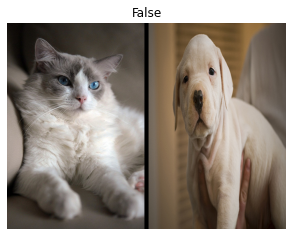

In [29]:
img = PILImage.create(files[0])
img1 = PILImage.create(files[1])
s = SiameseImage(img, img1, False)
s.show();

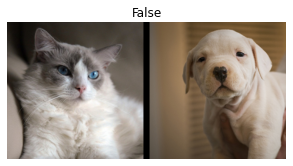

In [30]:
tst = Resize(224)(s)
tst = ToTensor()(tst)
tst.show();

# เปลี่ยน Transform ไปใช้ SiameseImage

เปลี่ยน Transform ไปใช้ SiameseImage จะได้สามารถโชว์ได้ เหมือนด้านบน

In [0]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
    def encodes(self, f):
        f2, same = self.valid.get(f, self._draw(f))
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        return SiameseImage(img1, img2, same)

    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls))
        return random.choice(lbl2files[cls]), same

In [0]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)

In [0]:
tls = TfmdLists(files, tfms=tfm, splits=splits)

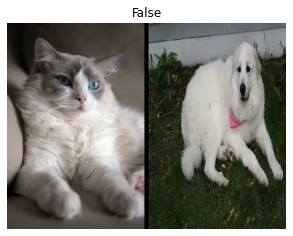

In [34]:
show_at(tls, 0)

In [0]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

แต่ตอนนี้ยัง show_batch ไม่ได้ เนื่องจาก

In [42]:
b = dls.one_batch()
type(b)

__main__.SiameseImage

{__main__.SiameseImage: [fastai2.torch_core.TensorImage,
  fastai2.torch_core.TensorImage,
  torch.Tensor]}

In [0]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], x[2][i].item()).show(ctx=ctx)

In [0]:
b = dls.one_batch()

In [46]:
dls._types

{__main__.SiameseImage: [fastai2.torch_core.TensorImage,
  fastai2.torch_core.TensorImage,
  torch.Tensor]}

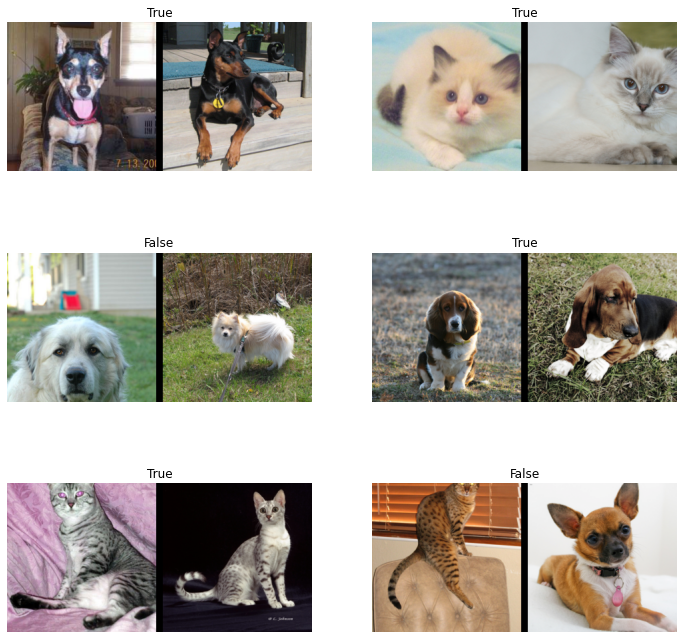

In [47]:
dls.show_batch()

# Creating Custom DataBlock

# Credit 

* https://dev.fast.ai/tutorial.siamese